In [97]:
import vaex
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re

print(os.getcwd())

# Read in the data


/Users/macos/Financial-Big-Data/Labs


In [9]:
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    try:
        if re.search('(csv|csv\\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search('parquet$',filename):
            DF = pd.read_parquet(filename)

    except Exception as e:
     #   print("load_TRTH_trade could not load "+filename)
     #   print(e)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    
    if DF.shape[0]==0:
        return None
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF


def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
       # print("load_TRTH_bbo could not load "+filename)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
       # print("load_TRTH_bbo could not load "+filename)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
       # print("load_TRTH_bbo could not load "+filename)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
        DF=DF.groupby(DF.index).last()
    

        
    return DF

In [10]:
def load_merge_trade_bbo(ticker,date,
                         country="US",
                         dirBase="../data/raw/TRTH/equities/",
                         suffix="parquet",
                         suffix_save=None,
                         dirSaveBase="../data/clean/TRTH/equities/events",
                         saveOnly=False,
                         doSave=False
                        ):
    
    file_trade=dirBase+"/"+country+"/trade/"+ticker+"/"+str(date.date())+"-"+ticker+"-trade."+suffix
    file_bbo=file_trade.replace("trade","bbo")
    trades=load_TRTH_trade(file_trade)
    bbos  =load_TRTH_bbo(file_bbo)
    try:
        trades.shape + bbos.shape
    except:
        return None
    
    events=trades.join(bbos,how="outer")
    
    if doSave:
        dirSave=dirSaveBase+"/"+country+"/events/"+ticker
        if not os.path.isdir(dirSave):
            os.makedirs(dirSave)

        if suffix_save:
            suffix=suffix_save
        
        file_events=dirSave+"/"+str(date.date())+"-"+ticker+"-events"+"."+suffix
       # pdb.set_trace()

        saved=False
        if suffix=="arrow":
            events=vaex.from_pandas(events,copy_index=True)
            events.export_arrow(file_events)
            saved=True
        if suffix=="parquet":
         #   pdb.set_trace()
            events.to_parquet(file_events,use_deprecated_int96_timestamps=True)
            saved=True
            
        if not saved:
            print("suffix "+suffix+" : format not recognized")
            
        if saveOnly:
            return saved
    return events

In [61]:
from datetime import datetime

ticker="LMT.N"

startDate="2010-01-01"
endDate="2010-12-31"

datelist = pd.date_range(startDate,endDate).tolist()

In [108]:
trades = vaex.open("../data/raw/TRTH/equities/US/trade/LMT.N/20[04][08]*parquet")
bbos   = vaex.open("../data/raw/TRTH/equities/US/bbo/LMT.N/20[04][08]*parquet")
events = trades.join(bbos, how="left", on="xltime", allow_duplication=True)
events["Date"] = pd.to_datetime(events["xltime"].values ,unit="d",origin="1899-12-30", utc=True).values
events["Date"] = pd.DatetimeIndex(events["Date"].values).tz_localize("America/New_York").values
events

#,xltime,trade-price,trade-volume,trade-stringflag,trade-rawflag,bid-price,bid-volume,ask-price,ask-volume,Date
0,39449.60529497685,105.26,28300,uncategorized,'[GEN ]Open ...,--,--,--,--,2008-01-02 19:31:37.485999872
1,39449.60529497685,105.29,100,uncategorized,[GEN ]High,--,--,--,--,2008-01-02 19:31:37.485999872
2,39449.60529497685,105.29,100,uncategorized,,--,--,--,--,2008-01-02 19:31:37.485999872
3,39449.60530538195,105.29,100,uncategorized,,--,--,--,--,2008-01-02 19:31:38.385000448
4,39449.60536886574,105.33,100,uncategorized,'[CTS ]MSW ...,--,--,--,--,2008-01-02 19:31:43.870000128
...,...,...,...,...,...,...,...,...,...,...
"1,306,742",39813.87163490741,84.22,400,uncategorized,,84.19,7,84.31,72,2009-01-01 01:55:09.256000256
"1,306,743",39813.87233677084,84.44,400,uncategorized,,84.42,1,84.47,11,2009-01-01 01:56:09.897000448
"1,306,744",39813.87233677084,84.42,100,uncategorized,,84.42,1,84.47,11,2009-01-01 01:56:09.897000448
"1,306,745",39813.87471273148,84.24,100,uncategorized,,84.21,22,84.25,3,2009-01-01 01:59:35.179999744


In [111]:
events = events[events["trade-stringflag"] == "uncategorized"]
events = events[events["bid-price"].notna()]
events = events.extract()

In [112]:
events["Sign"] = np.concatenate(([0], np.sign(events["trade-price"].values[1:] - (events["bid-price"].values[:-1]+events["ask-price"].values[:-1])/2)))
events

#,xltime,trade-price,trade-volume,trade-stringflag,trade-rawflag,bid-price,bid-volume,ask-price,ask-volume,Date,Sign
0,39449.60809430556,106.01,200,uncategorized,,105.89,2,106.01,2,2008-01-02 19:35:39.348000000,0.0
1,39449.60836293982,105.82,100,uncategorized,,105.78,1,106.02,5,2008-01-02 19:36:02.558000384,-1.0
2,39449.60878582176,105.92,500,uncategorized,,105.79,1,106.02,3,2008-01-02 19:36:39.094999808,1.0
3,39449.61045480324,106.3,100,uncategorized,,106.26,1,106.5,8,2008-01-02 19:39:03.294999808,1.0
4,39449.61074988426,106.4,100,uncategorized,,106.28,1,106.43,1,2008-01-02 19:39:28.790000128,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"190,695",39813.87163490741,84.22,400,uncategorized,,84.19,7,84.31,72,2009-01-01 01:55:09.256000256,-1.0
"190,696",39813.87233677084,84.44,400,uncategorized,,84.42,1,84.47,11,2009-01-01 01:56:09.897000448,1.0
"190,697",39813.87233677084,84.42,100,uncategorized,,84.42,1,84.47,11,2009-01-01 01:56:09.897000448,-1.0
"190,698",39813.87471273148,84.24,100,uncategorized,,84.21,22,84.25,3,2009-01-01 01:59:35.179999744,-1.0


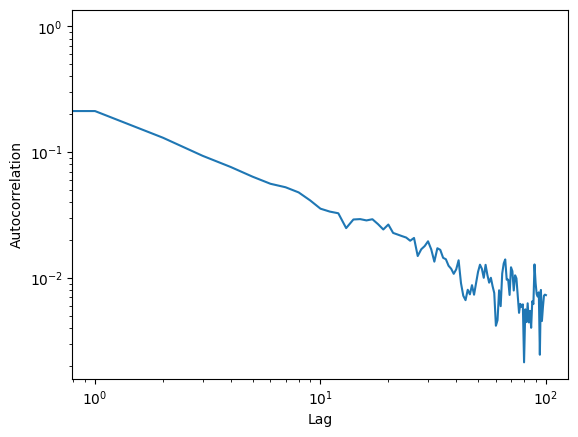

In [116]:
s = events["Sign"].values
s = np.trim_zeros(s)
autocorr = sm.tsa.acf(s, nlags=100)
sns.lineplot(x=np.arange(autocorr.shape[0]), y=autocorr)
plt.xscale("log")
plt.xlabel("Lag")
plt.yscale("log")
plt.ylabel("Autocorrelation")
plt.show()